In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [7]:
ind_time_filepath = "../output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"
raw_data = "../PROM-RulesBasedAlgorithmData_R2.0.xlsx"
# ind_time_filepath = "../output_data_pilot/Simulation_Results_2023-08-03T134722.370088/individual_time_point_data.csv"

In [8]:
domain_code_to_name = {"ui_domain" : "Urinary Incontinence Domain",
                      "sf_domain" : "Sexual Function Domain",
                       "uio_domain" : "Urinary Obstruction Domain",
                       "bf_domain" : "Bowel Function Domain",
                       "hf_domain" : "Hormonal Function Domain",
                       "q6d" : "Blood Stools Question"
                      }

In [9]:
unfiltered_ind_time_df = pd.read_csv(ind_time_filepath)
unfiltered_raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(unfiltered_ind_time_df))
print(unfiltered_ind_time_df.head())
print(len(unfiltered_raw_data_df))
print(unfiltered_raw_data_df.head())

16319
  Patient Identifier           Time Point Urinary Incontinence Domain State  \
0  15970_370765.json  2019-04-09 00:00:00                            Normal   
1  15970_413565.json  2020-12-05 00:00:00                          Abnormal   
2   9204_198609.json  2015-05-12 00:00:00                            Normal   
3   9204_235725.json  2015-11-04 00:00:00                            Normal   
4   9204_279366.json  2016-08-29 22:25:00                            Normal   

  Urinary Irritation/Obstruction Domain State Bowel Function Domain State  \
0                     Clinically Urgent Alert                      Normal   
1                     Clinically Urgent Alert                      Normal   
2                                      Normal                      Normal   
3                                      Normal                    Abnormal   
4                     Clinically Urgent Alert                      Normal   

  Q6d State Sexual Function Domain State Hormonal Functi

# Preprocessing

In [10]:
# Remove participants with missing age data
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['AgeAtDx'].isin(list(range(0, 100))))]

# Format as [(participant_id, report_id)]
participant_df = list(participant_df['CapstudiesID'])
report_id_data = unfiltered_raw_data_df.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id if participant_id in participant_df]

# Filter raw data
filtered_raw_data_df1 = unfiltered_raw_data_df[(unfiltered_raw_data_df[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df1 = unfiltered_ind_time_df[(unfiltered_ind_time_df['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count0 = len(set(unfiltered_raw_data_df['CapstudiesID']))
participant_count1 = len(set(filtered_raw_data_df1['CapstudiesID']))
print(f"{participant_count0} -> {participant_count1} participants")
print(f"{len(unfiltered_raw_data_df)} -> {len(filtered_raw_data_df1)} alerts")

5147 -> 4935 participants
16319 -> 15717 alerts


In [11]:
# Remove participants with null values for questionnaire responses
m=filtered_ind_time_df1.isnull().sum(axis=1)
m=m[~m.isin([0])].index.unique()

report_id_data = unfiltered_raw_data_df.loc[m].groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id]

# Filter raw data
filtered_raw_data_df2 = filtered_raw_data_df1[(filtered_raw_data_df1[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df2 = filtered_ind_time_df1[(filtered_ind_time_df1['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count2 = len(set(filtered_raw_data_df2['CapstudiesID']))
print(f"{participant_count1} -> {participant_count2} participants")
print(f"{len(filtered_ind_time_df1)} -> {len(filtered_ind_time_df2)} alerts")

4935 -> 4933 participants
15717 -> 15127 alerts


## Keep first 4 reports for participants with >=4 reports

In [12]:
# keep participants with at least 4 reports
report_id_data = filtered_raw_data_df2.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
interval_data = filtered_raw_data_df2.groupby('CapstudiesID')['Interval'].apply(list).to_dict()
keep_ids = [] # [(patient_id, report_id)]
participant_count3 = 0
for id in report_id_data.keys():
    if len(interval_data[id]) >= 4 and len(interval_data[id]) == len(list(set(interval_data[id]))):
        participant_count3 += 1
        to_keep = list(zip(report_id_data[id], interval_data[id]))
        to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
        keep_ids += [(id, x[0]) for x in to_keep[:4]] # keep first 4 reports

# Filter raw data
filtered_raw_data_df3 = filtered_raw_data_df2[(filtered_raw_data_df2[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df3 = filtered_ind_time_df2[(filtered_ind_time_df2['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count2} -> {participant_count3} participants")
print(f"{len(filtered_ind_time_df2)} -> {len(filtered_ind_time_df3)} alerts")
date_points = ["0", "3", "6-12", "24-60"] # measured in months

4933 -> 1412 participants
15127 -> 5648 alerts


## Sort by initial alert type

In [78]:
report_id_data = filtered_raw_data_df3.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
interval_data = filtered_raw_data_df3.groupby('CapstudiesID')['Interval'].apply(list).to_dict()
alert_data = filtered_ind_time_df3.groupby('Patient Identifier')['Final Alert State'].apply(list).to_dict()

normal_ids = [] # [(patient_id, report_id)]
urgent_ids = [] # [(patient_id, report_id)]
for id in report_id_data.keys():
    to_keep = list(zip(report_id_data[id], interval_data[id], [alert_data[f"{id}_{report_id}.json"][0] for report_id in report_id_data[id]]))
    to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
    if to_keep[0][2] == 'Normal':
        normal_ids += [(id, x[0]) for x in to_keep]
    elif to_keep[0][2] == 'Clinically Urgent Alert':
        urgent_ids += [(id, x[0]) for x in to_keep]

print("Starting normal:")
keep_ids = normal_ids

normal_participant_count4 = len(set([id[0] for id in keep_ids]))

# Filter raw data
normal_filtered_raw_data_df4 = filtered_raw_data_df3[(filtered_raw_data_df3[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
normal_filtered_ind_time_df4 = filtered_ind_time_df3[(filtered_ind_time_df3['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count3} -> {normal_participant_count4} participants")
print(f"{len(filtered_ind_time_df3)} -> {len(normal_filtered_ind_time_df4)} alerts")

print("Starting urgent:")
keep_ids = urgent_ids
urgent_participant_count4 = len(set([id[0] for id in keep_ids]))

# Filter raw data
urgent_filtered_raw_data_df4 = filtered_raw_data_df3[(filtered_raw_data_df3[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
urgent_filtered_ind_time_df4 = filtered_ind_time_df3[(filtered_ind_time_df3['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count3} -> {urgent_participant_count4} participants")
print(f"{len(filtered_ind_time_df3)} -> {len(urgent_filtered_raw_data_df4)} alerts")

Starting normal:
1412 -> 640 participants
5648 -> 2560 alerts
Starting urgent:
1412 -> 753 participants
5648 -> 3012 alerts


## Viewing Distributions After Baseline Segmentation

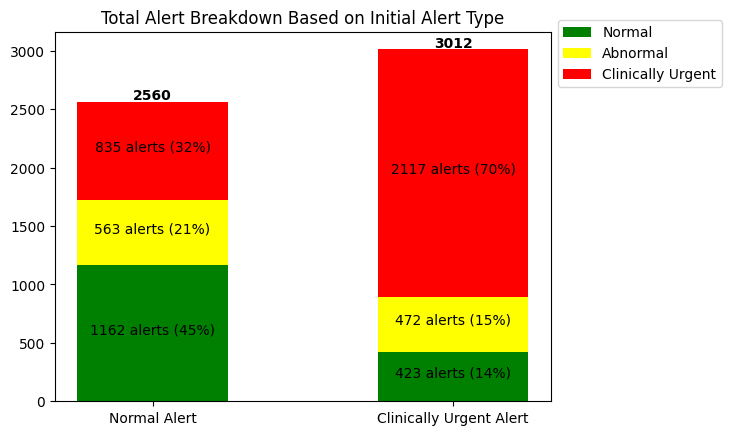

In [14]:
# Look at the frequency for the different types of alerts (normal, abnormal, clinically urgent)
alert_counts_normal = normal_filtered_ind_time_df4['Final Alert State'].value_counts()
alert_counts_urgent = urgent_filtered_ind_time_df4['Final Alert State'].value_counts()

start_alert = (
    "Normal Alert",
    "Clinically Urgent Alert",
)
alert_counts = {
    "Normal": np.array([alert_counts_normal['Normal'], alert_counts_urgent['Normal']]),
    "Abnormal": np.array([alert_counts_normal['Abnormal'], alert_counts_urgent['Abnormal']]),
    "Clinically Urgent": np.array([alert_counts_normal['Clinically Urgent Alert'], alert_counts_urgent['Clinically Urgent Alert']]),
}

total_alert_counts = [len(normal_filtered_raw_data_df4), len(urgent_filtered_raw_data_df4)]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(start_alert, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_alert_counts[i%2])}%)", ha = 'center',
      color = 'black', size = 10)

# Total Labels
for i in range(len(total_alert_counts)): 
    ax.text(i, total_alert_counts[i] + 20, round(total_alert_counts[i]), ha = 'center', weight = 'bold', color = 'black')
    
ax.set_title("Total Alert Breakdown Based on Initial Alert Type")
ax.legend(bbox_to_anchor=(1, 1.05))


plt.show()

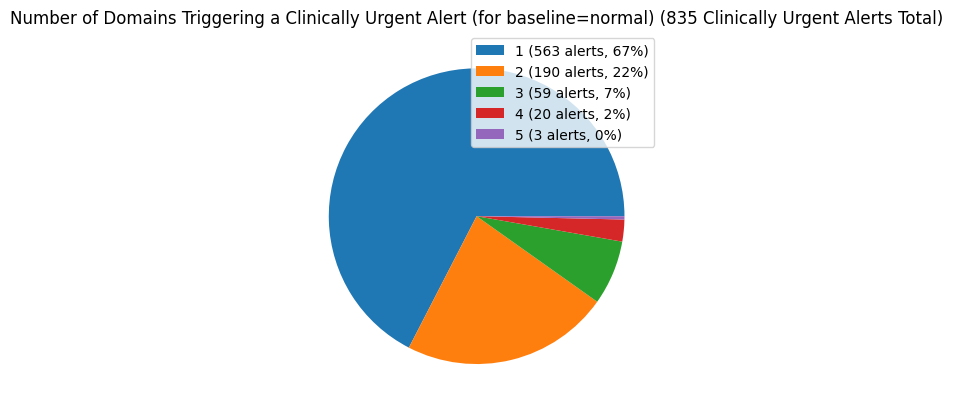

In [15]:
# Number of domains triggering a normal alert
no_triggering_domains = normal_filtered_ind_time_df4.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert (for baseline=normal) ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

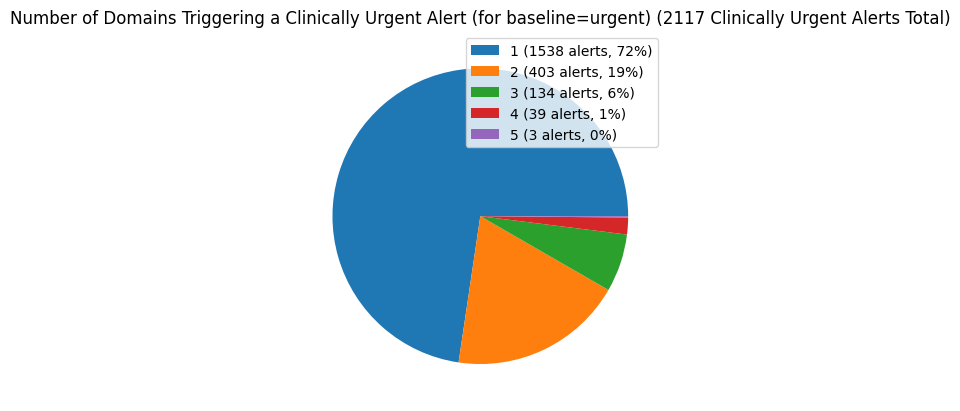

In [16]:
# Number of domains triggering a clinically urgent alert
no_triggering_domains = urgent_filtered_ind_time_df4.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert (for baseline=urgent) ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

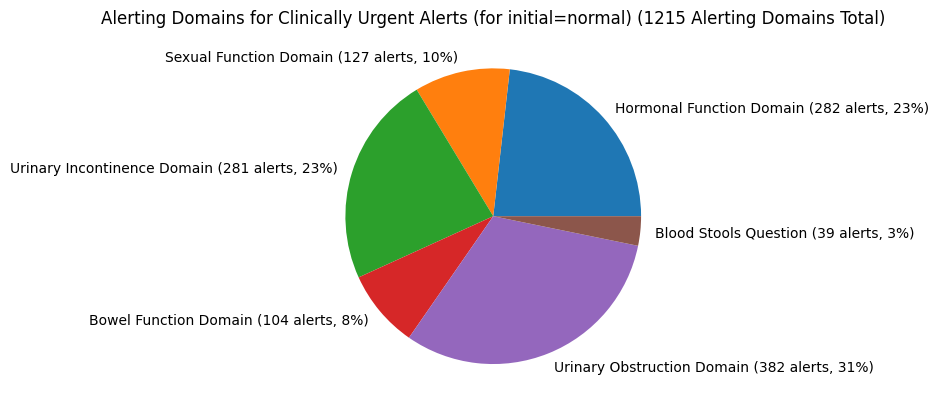

In [17]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(normal_filtered_ind_time_df4[normal_filtered_ind_time_df4['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts (for initial=normal) ({total_alerts} Alerting Domains Total)")
plt.show()

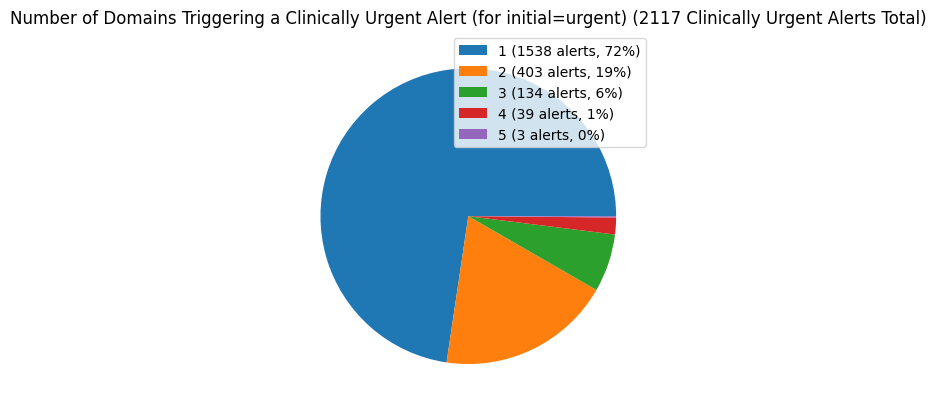

In [18]:
# Number of domains triggering a clinically urgent alert
no_triggering_domains = urgent_filtered_ind_time_df4.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert (for initial=urgent) ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

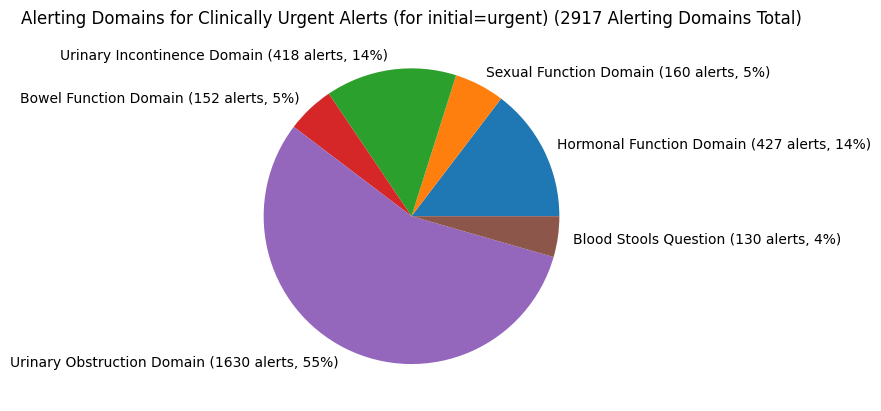

In [19]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(urgent_filtered_ind_time_df4[urgent_filtered_ind_time_df4['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts (for initial=urgent) ({total_alerts} Alerting Domains Total)")
plt.show()

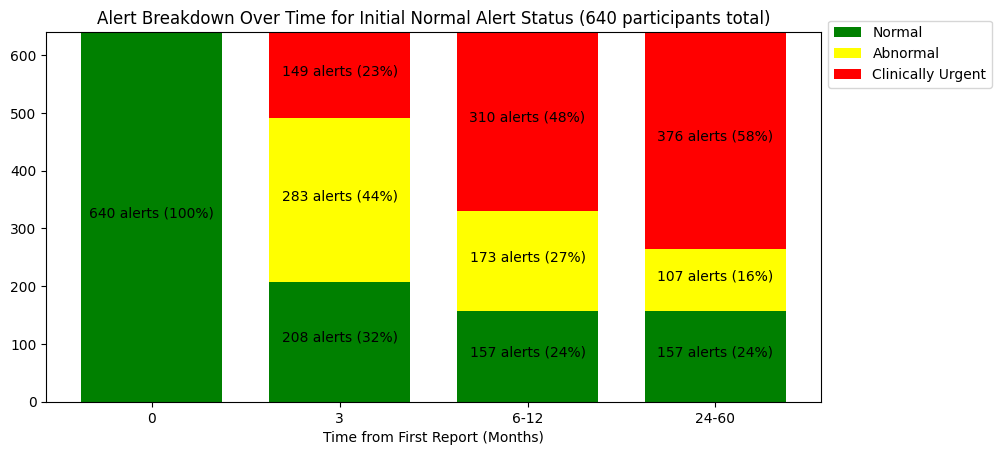

In [20]:
# Alerts by report number
alert_types = list(normal_filtered_ind_time_df4['Final Alert State'])
alert_times = list(normal_filtered_ind_time_df4['Time Point'])
patient_ids = list(normal_filtered_ind_time_df4['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

old_counts = alert_counts
alert_counts = { 
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
overall_normal_alert_counts = alert_counts

total_alert_counts = [sum(old_counts[date].values()) for date in date_points]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/normal_participant_count4)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Initial Normal Alert Status ({normal_participant_count4} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


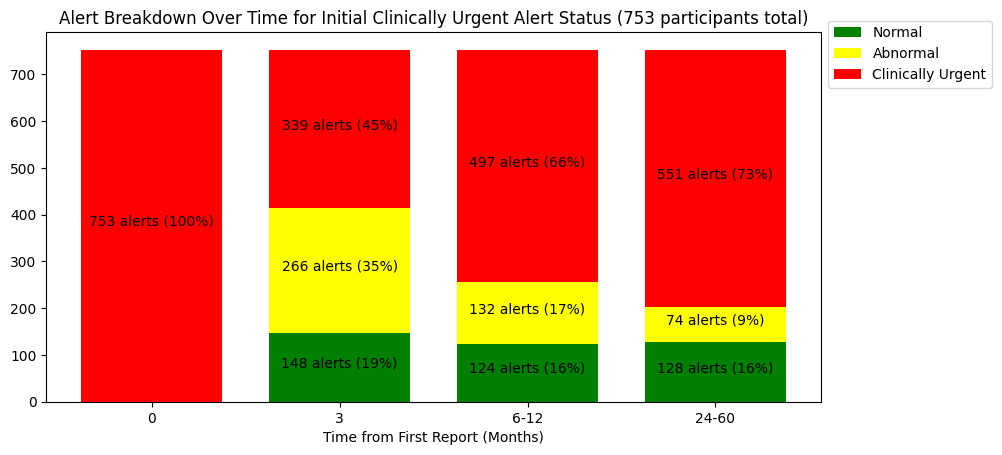

In [21]:
# Alerts by report number
alert_types = list(urgent_filtered_ind_time_df4['Final Alert State'])
alert_times = list(urgent_filtered_ind_time_df4['Time Point'])
patient_ids = list(urgent_filtered_ind_time_df4['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

alert_counts[date_points[0]] = {"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": urgent_participant_count4}
old_counts = alert_counts
alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}

overall_urgent_alert_counts = alert_counts

total_alert_counts = [sum(old_counts[date].values()) for date in date_points]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/urgent_participant_count4)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Initial Clinically Urgent Alert Status ({urgent_participant_count4} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


In [22]:
overall_total_alert_counts = {}
for type in ['Normal', 'Abnormal', 'Clinically Urgent']:
    overall_total_alert_counts[type] = [overall_normal_alert_counts[type][report_no] + overall_urgent_alert_counts[type][report_no] for report_no in range(len(overall_normal_alert_counts[type]))]

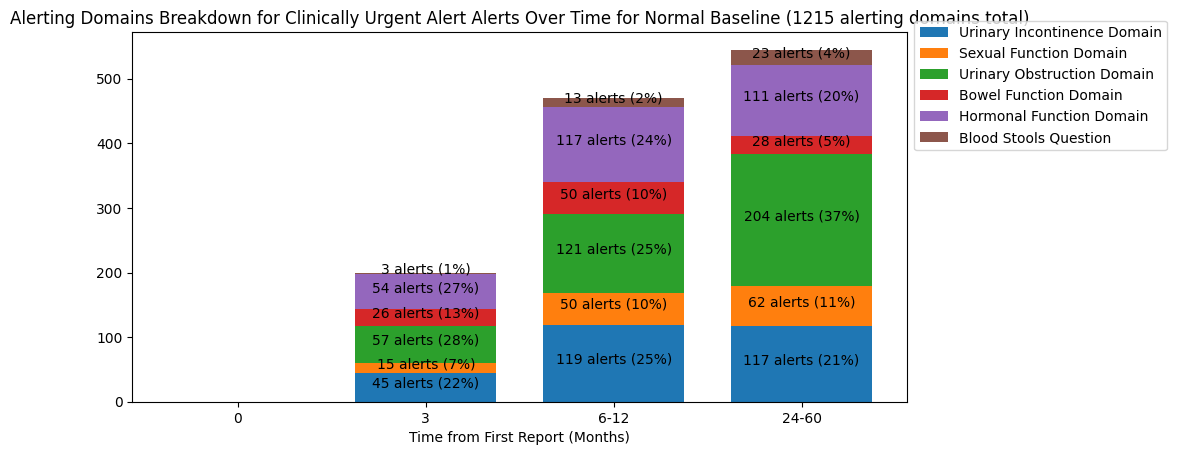

In [23]:
# Alerts by report number
alert_filter_type = "Clinically Urgent Alert"
alert_types = list(normal_filtered_ind_time_df4['Final Alert State'])
alert_times = list(normal_filtered_ind_time_df4['Time Point'])
patient_ids = list(normal_filtered_ind_time_df4['Patient Identifier'])
alerting_domains = list(normal_filtered_ind_time_df4['Alerting Domains'])
alerts_by_patient = {} # {id : [(datetime, alert_type, alerting_domains)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i], alerting_domains[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i], alerting_domains[i]))

alert_counts = zip(date_points, [{"ui_domain": 0, "sf_domain": 0, "uio_domain": 0, "bf_domain": 0, "hf_domain":0, "q6d":0} for date in date_points])
alert_counts = dict(alert_counts)
domain_list = ["ui_domain", "sf_domain", "uio_domain", "bf_domain", "hf_domain", "q6d"]
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][2]) for i in range(len(alerts_by_patient[patient_id])) if alerts_by_patient[patient_id][i][1] == alert_filter_type]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        for domain in domain_list:
            if domain in sorted_alerts[i][1]:
                alert_counts[date_points[i]][domain] += 1

old_counts = alert_counts
alert_counts = { 
    domain_code_to_name["ui_domain"]: np.flip(np.array([old_counts[date]["ui_domain"] for date in date_points]), 0),
    domain_code_to_name["sf_domain"]: np.flip(np.array([old_counts[date]["sf_domain"] for date in date_points]), 0),
    domain_code_to_name["uio_domain"]: np.flip(np.array([old_counts[date]["uio_domain"] for date in date_points]), 0),
    domain_code_to_name["bf_domain"]: np.flip(np.array([old_counts[date]["bf_domain"] for date in date_points]), 0),
    domain_code_to_name["hf_domain"]: np.flip(np.array([old_counts[date]["hf_domain"] for date in date_points]), 0),
    domain_code_to_name["q6d"]: np.flip(np.array([old_counts[date]["q6d"] for date in date_points]), 0),
}

total_alert_counts = sum([sum(old_counts[date].values()) for date in date_points])
total_domain_counts = [sum(old_counts[date].values()) for date in date_points][::-1]

width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom)
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_domain_counts[i%len(total_domain_counts)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alerting Domains Breakdown for {alert_filter_type} Alerts Over Time for Normal Baseline ({total_alert_counts} alerting domains total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()

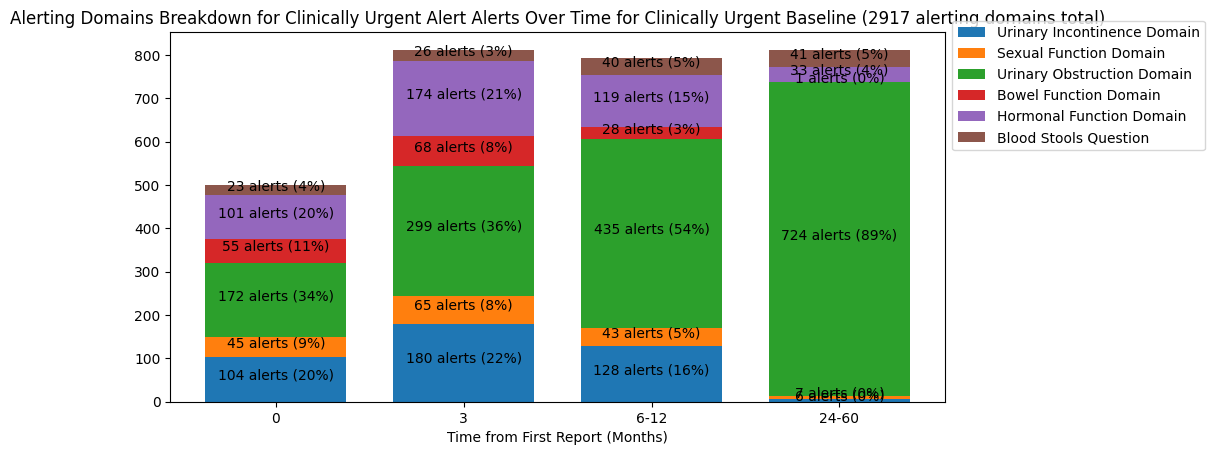

In [24]:
# Alerts by report number
alert_filter_type = "Clinically Urgent Alert"
alert_types = list(urgent_filtered_ind_time_df4['Final Alert State'])
alert_times = list(urgent_filtered_ind_time_df4['Time Point'])
patient_ids = list(urgent_filtered_ind_time_df4['Patient Identifier'])
alerting_domains = list(urgent_filtered_ind_time_df4['Alerting Domains'])
alerts_by_patient = {} # {id : [(datetime, alert_type, alerting_domains)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i], alerting_domains[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i], alerting_domains[i]))

alert_counts = zip(date_points, [{"ui_domain": 0, "sf_domain": 0, "uio_domain": 0, "bf_domain": 0, "hf_domain":0, "q6d":0} for date in date_points])
alert_counts = dict(alert_counts)
domain_list = ["ui_domain", "sf_domain", "uio_domain", "bf_domain", "hf_domain", "q6d"]
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][2]) for i in range(len(alerts_by_patient[patient_id])) if alerts_by_patient[patient_id][i][1] == alert_filter_type]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        for domain in domain_list:
            if domain in sorted_alerts[i][1]:
                alert_counts[date_points[i]][domain] += 1

old_counts = alert_counts
alert_counts = { 
    domain_code_to_name["ui_domain"]: np.flip(np.array([old_counts[date]["ui_domain"] for date in date_points]), 0),
    domain_code_to_name["sf_domain"]: np.flip(np.array([old_counts[date]["sf_domain"] for date in date_points]), 0),
    domain_code_to_name["uio_domain"]: np.flip(np.array([old_counts[date]["uio_domain"] for date in date_points]), 0),
    domain_code_to_name["bf_domain"]: np.flip(np.array([old_counts[date]["bf_domain"] for date in date_points]), 0),
    domain_code_to_name["hf_domain"]: np.flip(np.array([old_counts[date]["hf_domain"] for date in date_points]), 0),
    domain_code_to_name["q6d"]: np.flip(np.array([old_counts[date]["q6d"] for date in date_points]), 0),
}

total_alert_counts = sum([sum(old_counts[date].values()) for date in date_points])
total_domain_counts = [sum(old_counts[date].values()) for date in date_points][::-1]

width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom)
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_domain_counts[i%len(total_domain_counts)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alerting Domains Breakdown for {alert_filter_type} Alerts Over Time for Clinically Urgent Baseline ({total_alert_counts} alerting domains total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()

# Filtering for Segmentations

In [109]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")

# AGE
age_groups = ["40-64", "65-69", "70+"]

# NORMAL BASELINE
keep_ids = zip(age_groups, [list(participant_df[(participant_df["AgeAtDx"] < 65)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 65) & (participant_df["AgeAtDx"] < 70)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 70)]["CapstudiesID"])])
keep_ids = dict(keep_ids)
# Filter raw data
normal_filtered_raw_data_df5 = zip(age_groups, [normal_filtered_raw_data_df4[normal_filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[a])] for a in age_groups])
normal_filtered_raw_data_df5 = dict(normal_filtered_raw_data_df5)

# Filter alg output data
normal_filtered_ind_time_df5 = {}
for a in age_groups:
    keep_ids[a] = [str(pid) for pid in keep_ids[a]]
    m=normal_filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[a])].index.unique()
    normal_filtered_ind_time_df5[a]=normal_filtered_ind_time_df4.loc[m]

normal_participant_count5 = [len(set(list(normal_filtered_raw_data_df5[a]['CapstudiesID']))) for a in age_groups]
normal_alert_count5 = [len(normal_filtered_ind_time_df5[a]) for a in age_groups]

print("normal baseline:")
print(f"{normal_participant_count4} -> {sum(normal_participant_count5)}({normal_participant_count5}) participants")
print(f"{len(normal_filtered_ind_time_df4)} -> {sum(normal_alert_count5)}({normal_alert_count5}) alerts")

# URGENT BASELINE
keep_ids = zip(age_groups, [list(participant_df[(participant_df["AgeAtDx"] < 65)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 65) & (participant_df["AgeAtDx"] < 70)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 70)]["CapstudiesID"])])
keep_ids = dict(keep_ids)

# Filter raw data
urgent_filtered_raw_data_df5 = zip(age_groups, [urgent_filtered_raw_data_df4[urgent_filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[a])] for a in age_groups])
urgent_filtered_raw_data_df5 = dict(urgent_filtered_raw_data_df5)

# Filter alg output data
urgent_filtered_ind_time_df5 = {}
for a in age_groups:
    keep_ids[a] = [str(pid) for pid in keep_ids[a]]
    m=urgent_filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[a])].index.unique()
    urgent_filtered_ind_time_df5[a]=urgent_filtered_ind_time_df4.loc[m]

urgent_participant_count5 = [len(set(list(urgent_filtered_raw_data_df5[a]['CapstudiesID']))) for a in age_groups]
urgent_alert_count5 = [len(urgent_filtered_ind_time_df5[a]) for a in age_groups]

print("\nurgent baseline:")
print(f"{urgent_participant_count4} -> {sum(urgent_participant_count5)}({urgent_participant_count5}) participants")
print(f"{len(urgent_filtered_ind_time_df4)} -> {sum(urgent_alert_count5)}({urgent_alert_count5}) alerts")

normal baseline:
640 -> 640([247, 192, 201]) participants
2560 -> 2560([988, 768, 804]) alerts

urgent baseline:
753 -> 753([240, 254, 259]) participants
3012 -> 3012([960, 1016, 1036]) alerts


In [27]:
# TREATMENT TYPE
therapies = ["RP", "XRT", "OBSERVATION"]
# therapies = ["RP", "XRT", "OBSERVATION", "HORMONES", "OTHER"] # use this to view counts
# NORMAL BASELINE

keep_ids = zip(therapies, [list(participant_df[(participant_df["iTreatment"] == t)]["CapstudiesID"]) for t in therapies])
keep_ids = dict(keep_ids)

# Filter raw data
normal_filtered_raw_data_df5 = zip(therapies, [normal_filtered_raw_data_df4[normal_filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[t])] for t in therapies])
normal_filtered_raw_data_df5 = dict(normal_filtered_raw_data_df5)

# Filter alg output data
normal_filtered_ind_time_df5 = {}
for t in therapies:
    keep_ids[t] = [str(pid) for pid in keep_ids[t]]
    m=normal_filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[t])].index.unique()
    normal_filtered_ind_time_df5[t]=normal_filtered_ind_time_df4.loc[m]

normal_participant_count5 = [len(set(list(normal_filtered_raw_data_df5[t]['CapstudiesID']))) for t in therapies]
normal_alert_count5 = [len(normal_filtered_ind_time_df5[t]) for t in therapies]

print("normal baseline:")
print(f"{normal_participant_count4} -> {sum(normal_participant_count5)}({normal_participant_count5}) participants")
print(f"{len(normal_filtered_ind_time_df4)} -> {sum(normal_alert_count5)}({normal_alert_count5}) alerts")

# URGENT BASELINE

keep_ids = zip(therapies, [list(participant_df[(participant_df["iTreatment"] == t)]["CapstudiesID"]) for t in therapies])
keep_ids = dict(keep_ids)

# Filter raw data
urgent_filtered_raw_data_df5 = zip(therapies, [urgent_filtered_raw_data_df4[urgent_filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[t])] for t in therapies])
urgent_filtered_raw_data_df5 = dict(urgent_filtered_raw_data_df5)

# Filter alg output data
urgent_filtered_ind_time_df5 = {}
for t in therapies:
    keep_ids[t] = [str(pid) for pid in keep_ids[t]]
    m=urgent_filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[t])].index.unique()
    urgent_filtered_ind_time_df5[t]=urgent_filtered_ind_time_df4.loc[m]

urgent_participant_count5 = [len(set(list(urgent_filtered_raw_data_df5[t]['CapstudiesID']))) for t in therapies]
urgent_alert_count5 = [len(urgent_filtered_ind_time_df5[t]) for t in therapies]

print("\nurgent baseline:")
print(f"{urgent_participant_count4} -> {sum(urgent_participant_count5)}({urgent_participant_count5}) participants")
print(f"{len(urgent_filtered_ind_time_df4)} -> {sum(urgent_alert_count5)}({urgent_alert_count5}) alerts")

normal baseline:
640 -> 616([505, 61, 50]) participants
2560 -> 2464([2020, 244, 200]) alerts

urgent baseline:
753 -> 708([540, 114, 54]) participants
3012 -> 2832([2160, 456, 216]) alerts


In [110]:
normal_ind_time_df = normal_filtered_ind_time_df5
urgent_ind_time_df = urgent_filtered_ind_time_df5
total_ind_time_df = zip(normal_ind_time_df.keys(), [pd.concat([normal_ind_time_df[key], urgent_ind_time_df[key]]) for key in normal_ind_time_df.keys()])
total_ind_time_df = dict(total_ind_time_df)

normal_raw_data_df = normal_filtered_raw_data_df5
urgent_raw_data_df = urgent_filtered_raw_data_df5
total_raw_data_df = zip(normal_raw_data_df.keys(), [pd.concat([normal_raw_data_df[key], urgent_raw_data_df[key]]) for key in normal_raw_data_df.keys()])
total_raw_data_df = dict(total_raw_data_df)

normal_participant_count = normal_participant_count5
urgent_participant_count = urgent_participant_count5
total_participant_count = [normal_participant_count5[i] + urgent_participant_count5[i] for i in range(len(normal_participant_count5))]

normal_alert_count = normal_alert_count5
urgent_alert_count = urgent_alert_count5
total_alert_count = [normal_alert_count5[i] + urgent_participant_count5[i] for i in range(len(normal_participant_count5))]

# Viewing Alert Distributions

In [142]:
initial_status = "All"
# initial_status = "Normal"
# initial_status = "Clinically Urgent"

ind_time_df = {} 
raw_data_df = {}
participant_count = []
alert_count = []

if initial_status == "All":
    ind_time_df = total_ind_time_df 
    raw_data_df = total_raw_data_df
    participant_count = total_participant_count
    alert_count = total_alert_count
elif initial_status == "Normal":
    ind_time_df = normal_ind_time_df 
    raw_data_df = normal_raw_data_df
    participant_count = normal_participant_count
    alert_count = normal_alert_count
elif initial_status == "Clinically Urgent":
    ind_time_df = urgent_ind_time_df 
    raw_data_df = urgent_raw_data_df
    participant_count = urgent_participant_count
    alert_count = urgent_alert_count
else:
    raise Exception("Invalid initial status")

In [143]:
t = age_groups[1]

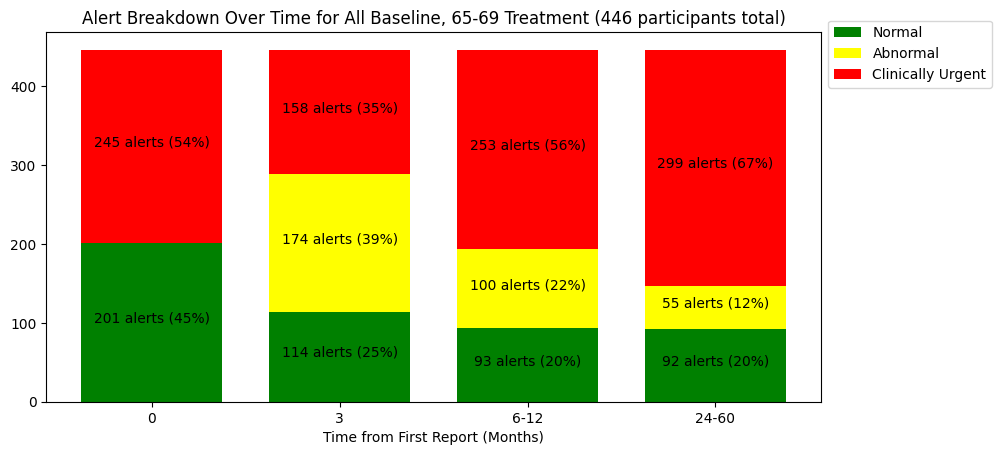

In [144]:
# Alerts by report number
alert_types = list(ind_time_df[t]['Final Alert State'])
alert_times = list(ind_time_df[t]['Time Point'])
patient_ids = list(ind_time_df[t]['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if i == 0:
            if initial_status == "Normal":
                alert_counts[date_points[i]]["Normal"] += 1
            elif initial_status == "Clinically Urgent":
                alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
            else:
                alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
            continue
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

old_counts = alert_counts
alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
total_participant_count = len(alerts_by_patient.keys())
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for {initial_status} Baseline, {t} Treatment ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


# Chi-Square Analysis

## Treatment vs Total

In [32]:
# Alerts by report number
treatment_alert_counts = {}
for t in therapies:
    alert_types = list(ind_time_df[t]['Final Alert State'])
    alert_times = list(ind_time_df[t]['Time Point'])
    patient_ids = list(ind_time_df[t]['Patient Identifier'])
    alerts_by_patient = {} # {id : [(datetime, alert_type)]}
    
    for i in range(len(alert_types)):
        patient_id = patient_ids[i].split('_')[0]
        time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
        if patient_id not in alerts_by_patient:
            alerts_by_patient[patient_id] = [(time, alert_types[i])]
        else:
            alerts_by_patient[patient_id].append((time, alert_types[i]))
            
    alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    alert_counts = dict(alert_counts)
    
    for patient_id in alerts_by_patient.keys():
        alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
        sorted_alerts = alerts_by_patient[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
    
    old_counts = alert_counts
    alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    treatment_alert_counts[t] = alert_counts


In [33]:
from scipy.stats import chi2_contingency
exp_alert_counts = []
if initial_status == "Normal":
    print("Normal Baseline:")
    exp_alert_counts = overall_normal_alert_counts
elif initial_status == "Clinically Urgent":
    print("Urgent Baseline:")
    exp_alert_counts = overall_urgent_alert_counts
elif initial_status == "All":
    print("All Baselines:")
    exp_alert_counts = overall_total_alert_counts 

for t in therapies:
    print(t)
    alert_counts = treatment_alert_counts[t]
    
    for report_no in range(1, 4):
        f_exp = np.array([exp_alert_counts["Normal"][report_no],
                          exp_alert_counts["Abnormal"][report_no],
                          exp_alert_counts["Clinically Urgent"][report_no]])
        f_obs = np.array([alert_counts["Normal"][report_no],
                          alert_counts["Abnormal"][report_no],
                          alert_counts["Clinically Urgent"][report_no]]) 
        stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
        print(f"report{report_no}: stat={stat},p={p}")
    print()

All Baselines:
RP
report1: stat=6.216163050712758,p=0.04468660327260008
report2: stat=2.1116795432125004,p=0.3479001479333704
report3: stat=0.9864572058336127,p=0.6106516563587601

XRT
report1: stat=60.208902460793986,p=8.429522028385334e-14
report2: stat=30.04859682440472,p=2.9855895715714036e-07
report3: stat=22.215386393892427,p=1.4996507805314993e-05

OBSERVATION
report1: stat=2.246920330870833,p=0.3251527635368857
report2: stat=0.5429606232792483,p=0.7622502907787254
report3: stat=0.1741013443179627,p=0.916630646802469



## Treatment vs Treatment

In [34]:
print(f"{initial_status} Baseline")
for i in range(len(therapies)):
    for j in range(i+1, len(therapies)):
        print(f"{therapies[i]} vs {therapies[j]}")
        for report_no in range(1, 4):
            alert_counts1 = treatment_alert_counts[therapies[i]]
            alert_counts2 = treatment_alert_counts[therapies[j]]
            f_exp = np.array([alert_counts1["Normal"][report_no],
                              alert_counts1["Abnormal"][report_no],
                              alert_counts1["Clinically Urgent"][report_no]])
            f_obs = np.array([alert_counts2["Normal"][report_no],
                              alert_counts2["Abnormal"][report_no],
                              alert_counts2["Clinically Urgent"][report_no]]) 
            stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
            print(f"report{report_no}: stat={stat},p={p}")
        print()

All Baseline
RP vs XRT
report1: stat=80.56080746317745,p=3.2095410193872773e-18
report2: stat=36.835083422439745,p=1.0031439646548783e-08
report3: stat=25.66347020157349,p=2.674534795975124e-06

RP vs OBSERVATION
report1: stat=3.0412095583534127,p=0.2185796545470208
report2: stat=0.25532885250991977,p=0.8801486843837409
report3: stat=0.2097125874125874,p=0.9004539141835102

XRT vs OBSERVATION
report1: stat=27.96530211213811,p=8.460807302470086e-07
report2: stat=17.95932666185004,p=0.00012594524223297272
report3: stat=13.429504216713523,p=0.0012128866391221782



## Normal vs Urgent Baseline

In [35]:
# Alerts by report number
normal_treatment_alert_counts = {}
for t in therapies:
    alert_types = list(normal_ind_time_df[t]['Final Alert State'])
    alert_times = list(normal_ind_time_df[t]['Time Point'])
    patient_ids = list(normal_ind_time_df[t]['Patient Identifier'])
    alerts_by_patient = {} # {id : [(datetime, alert_type)]}
    
    for i in range(len(alert_types)):
        patient_id = patient_ids[i].split('_')[0]
        time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
        if patient_id not in alerts_by_patient:
            alerts_by_patient[patient_id] = [(time, alert_types[i])]
        else:
            alerts_by_patient[patient_id].append((time, alert_types[i]))
            
    alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    alert_counts = dict(alert_counts)
    
    for patient_id in alerts_by_patient.keys():
        alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
        sorted_alerts = alerts_by_patient[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
    
    old_counts = alert_counts
    alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    normal_treatment_alert_counts[t] = alert_counts


In [36]:
# Alerts by report number
urgent_treatment_alert_counts = {}
for t in therapies:
    alert_types = list(urgent_ind_time_df[t]['Final Alert State'])
    alert_times = list(urgent_ind_time_df[t]['Time Point'])
    patient_ids = list(urgent_ind_time_df[t]['Patient Identifier'])
    alerts_by_patient = {} # {id : [(datetime, alert_type)]}
    
    for i in range(len(alert_types)):
        patient_id = patient_ids[i].split('_')[0]
        time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
        if patient_id not in alerts_by_patient:
            alerts_by_patient[patient_id] = [(time, alert_types[i])]
        else:
            alerts_by_patient[patient_id].append((time, alert_types[i]))
            
    alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    alert_counts = dict(alert_counts)
    
    for patient_id in alerts_by_patient.keys():
        alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
        sorted_alerts = alerts_by_patient[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
    
    old_counts = alert_counts
    alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    urgent_treatment_alert_counts[t] = alert_counts


In [37]:
exp_normal_alert_counts = {"Normal": [], "Abnormal": [], "Clinically Urgent": []}
alert_counts1 = normal_treatment_alert_counts["XRT"]
alert_counts2 = normal_treatment_alert_counts["XRT"]
alert_counts3 = normal_treatment_alert_counts["XRT"]
for report_no in range(1, 4):
    exp_normal_alert_counts["Normal"].append(alert_counts1["Normal"][report_no])
    exp_normal_alert_counts["Abnormal"].append(alert_counts1["Abnormal"][report_no])
    exp_normal_alert_counts["Clinically Urgent"].append(alert_counts1["Clinically Urgent"][report_no])
    # exp_normal_alert_counts["Normal"].append(np.array(alert_counts1["Normal"][report_no])+ np.array(alert_counts2["Normal"][report_no])+ np.array(alert_counts3["Normal"][report_no]))
    # exp_normal_alert_counts["Abnormal"].append(np.array(alert_counts1["Abnormal"][report_no])+ np.array(alert_counts2["Abnormal"][report_no])+ np.array(alert_counts3["Abnormal"][report_no]))
    # exp_normal_alert_counts["Clinically Urgent"].append(np.array(alert_counts1["Clinically Urgent"][report_no])+ np.array(alert_counts2["Clinically Urgent"][report_no])+ np.array(alert_counts3["Clinically Urgent"][report_no]))

In [38]:
exp_urgent_alert_counts = {"Normal": [], "Abnormal": [], "Clinically Urgent": []}
alert_counts1 = urgent_treatment_alert_counts["XRT"]
alert_counts2 = urgent_treatment_alert_counts["XRT"]
alert_counts3 = urgent_treatment_alert_counts["XRT"]
for report_no in range(1, 4):
    exp_urgent_alert_counts["Normal"].append(alert_counts1["Normal"][report_no])
    exp_urgent_alert_counts["Abnormal"].append(alert_counts1["Abnormal"][report_no])
    exp_urgent_alert_counts["Clinically Urgent"].append(alert_counts1["Clinically Urgent"][report_no])
    # exp_urgent_alert_counts["Normal"].append(np.array(alert_counts1["Normal"][report_no])+ np.array(alert_counts2["Normal"][report_no])+ np.array(alert_counts3["Normal"][report_no]))
    # exp_urgent_alert_counts["Abnormal"].append(np.array(alert_counts1["Abnormal"][report_no])+ np.array(alert_counts2["Abnormal"][report_no])+ np.array(alert_counts3["Abnormal"][report_no]))
    # exp_urgent_alert_counts["Clinically Urgent"].append(np.array(alert_counts1["Clinically Urgent"][report_no])+ np.array(alert_counts2["Clinically Urgent"][report_no])+ np.array(alert_counts3["Clinically Urgent"][report_no]))

In [39]:
print(exp_normal_alert_counts)
print(exp_urgent_alert_counts)

{'Normal': [9, 12, 12], 'Abnormal': [20, 9, 7], 'Clinically Urgent': [32, 40, 42]}
{'Normal': [11, 6, 7], 'Abnormal': [21, 9, 2], 'Clinically Urgent': [82, 99, 105]}


In [40]:
from scipy.stats import chi2_contingency
    
for report_no in range(0, 3):
    f_exp = np.array([exp_normal_alert_counts["Normal"][report_no],
                      exp_normal_alert_counts["Abnormal"][report_no],
                      exp_normal_alert_counts["Clinically Urgent"][report_no]])
    f_obs = np.array([exp_urgent_alert_counts["Normal"][report_no],
                      exp_urgent_alert_counts["Abnormal"][report_no],
                      exp_urgent_alert_counts["Clinically Urgent"][report_no]]) 
    stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
    print(f"report{report_no}: stat={stat},p={p}")

report0: stat=6.7190763737595125,p=0.0347513038476425
report1: stat=12.101737936656715,p=0.0023558139890439748
report2: stat=16.561169725194972,p=0.0002533889589639133


## Comparing PSA Values

In [51]:
psa_df = pd.read_excel(raw_data, sheet_name="PSA")
# Alerts by report number
psa_alert_counts = {'Normal PSA': {'Normal':[0 for date in date_points],
                               'Abnormal':[0 for date in date_points],
                               'Clinically Urgent':[0 for date in date_points]},
                    'Low PSA': {'Normal':[0 for date in date_points],
                               'Abnormal':[0 for date in date_points],
                               'Clinically Urgent':[0 for date in date_points]}}
for t in therapies:
    alert_types = list(ind_time_df[t]['Final Alert State'])
    alert_times = list(ind_time_df[t]['Time Point'])
    patient_ids = list(ind_time_df[t]['Patient Identifier'])

    alerts_by_patient_normal_psa = {} # {id : [(datetime, alert_type)]}
    alerts_by_patient_low_psa = {} # {id : [(datetime, alert_type)]}
    
    for i in range(len(alert_types)):
        patient_id = patient_ids[i].split('_')[0]
        psa_data = psa_df.loc[(psa_df['CapstudiesID'] == int(patient_id))]
        psa_data = psa_data.sort_values(by=['PsaDate'])
        if psa_data.empty:
            continue
        psa = psa_data.iloc[0]['Operator']

        time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
        if psa == '=':
            if patient_id not in alerts_by_patient_normal_psa:
                alerts_by_patient_normal_psa[patient_id] = [(time, alert_types[i])]
            else:
                alerts_by_patient_normal_psa[patient_id].append((time, alert_types[i]))
        else:
            if patient_id not in alerts_by_patient_low_psa:
                alerts_by_patient_low_psa[patient_id] = [(time, alert_types[i])]
            else:
                alerts_by_patient_low_psa[patient_id].append((time, alert_types[i]))
    normal_psa_alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    normal_psa_alert_counts = dict(normal_psa_alert_counts)
    
    for patient_id in alerts_by_patient_normal_psa.keys():
        alerts_by_patient_normal_psa[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient_normal_psa[patient_id] = [(i, alerts_by_patient_normal_psa[patient_id][i][1]) for i in range(len(alerts_by_patient_normal_psa[patient_id]))]    
        sorted_alerts = alerts_by_patient_normal_psa[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    normal_psa_alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    normal_psa_alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    normal_psa_alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            normal_psa_alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
    
    old_counts = normal_psa_alert_counts
    normal_psa_alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    psa_alert_counts['Normal PSA']['Normal'] = [psa_alert_counts['Normal PSA']['Normal'][i] + normal_psa_alert_counts['Normal'][i] for i in range(len(date_points))]
    psa_alert_counts['Normal PSA']['Abnormal'] = [psa_alert_counts['Normal PSA']['Abnormal'][i] + normal_psa_alert_counts['Abnormal'][i] for i in range(len(date_points))]
    psa_alert_counts['Normal PSA']['Clinically Urgent'] = [psa_alert_counts['Normal PSA']['Clinically Urgent'][i] + normal_psa_alert_counts['Clinically Urgent'][i] for i in range(len(date_points))]

    low_psa_alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    low_psa_alert_counts = dict(low_psa_alert_counts)
    
    for patient_id in alerts_by_patient_low_psa.keys():
        alerts_by_patient_low_psa[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient_low_psa[patient_id] = [(i, alerts_by_patient_low_psa[patient_id][i][1]) for i in range(len(alerts_by_patient_low_psa[patient_id]))]    
        sorted_alerts = alerts_by_patient_low_psa[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    low_psa_alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    low_psa_alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    low_psa_alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            low_psa_alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                
    old_counts = low_psa_alert_counts
    low_psa_alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    psa_alert_counts['Low PSA']["Normal"] = [psa_alert_counts['Low PSA']["Normal"][i] + low_psa_alert_counts["Normal"][i] for i in range(len(date_points))]
    psa_alert_counts['Low PSA']["Abnormal"] = [psa_alert_counts['Low PSA']["Abnormal"][i] + low_psa_alert_counts["Abnormal"][i] for i in range(len(date_points))]
    psa_alert_counts['Low PSA']["Clinically Urgent"] = [psa_alert_counts['Low PSA']["Clinically Urgent"][i] + low_psa_alert_counts["Clinically Urgent"][i] for i in range(len(date_points))]


In [52]:
print(f"{initial_status} Baseline")
for report_no in range(1, 4):
    alert_counts1 = psa_alert_counts['Normal PSA']
    alert_counts2 = psa_alert_counts['Low PSA']
    f_exp = np.array([alert_counts1["Normal"][report_no],
                      alert_counts1["Abnormal"][report_no],
                      alert_counts1["Clinically Urgent"][report_no]])
    f_obs = np.array([alert_counts2["Normal"][report_no],
                      alert_counts2["Abnormal"][report_no],
                      alert_counts2["Clinically Urgent"][report_no]]) 
    stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
    print(f"report{report_no}: stat={stat},p={p}")


Clinically Urgent Baseline
report1: stat=3.2598427988546064,p=0.19594497490889115
report2: stat=0.6067071162444706,p=0.7383380048191243
report3: stat=3.0723968497172076,p=0.215197638372845


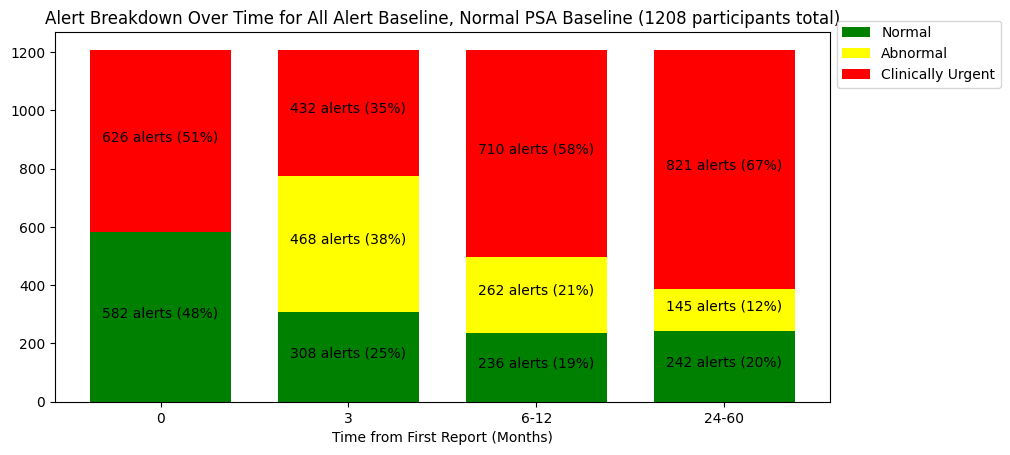

In [43]:
psa_class = 'Normal PSA'
alert_counts = psa_alert_counts[psa_class]
total_participant_count = sum([psa_alert_counts[psa_class][type][0] for type in ['Normal', 'Abnormal', 'Clinically Urgent']])
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for {initial_status} Alert Baseline, {psa_class} Baseline ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()

# Comparing Age Groups

In [145]:
print(ind_time_df.keys())

dict_keys(['40-64', '65-69', '70+'])


In [146]:
# Alerts by report number
age_alert_counts = {}
for a in age_groups:
    alert_types = list(ind_time_df[a]['Final Alert State'])
    alert_times = list(ind_time_df[a]['Time Point'])
    patient_ids = list(ind_time_df[a]['Patient Identifier'])
    alerts_by_patient = {} # {id : [(datetime, alert_type)]}
    
    for i in range(len(alert_types)):
        patient_id = patient_ids[i].split('_')[0]
        time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
        if patient_id not in alerts_by_patient:
            alerts_by_patient[patient_id] = [(time, alert_types[i])]
        else:
            alerts_by_patient[patient_id].append((time, alert_types[i]))
            
    alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
    alert_counts = dict(alert_counts)
    
    for patient_id in alerts_by_patient.keys():
        alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
        alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
        sorted_alerts = alerts_by_patient[patient_id]
        for i in range(len(sorted_alerts)):
            if i == 0:
                if initial_status == "Normal":
                    alert_counts[date_points[i]]["Normal"] += 1
                elif initial_status == "Clinically Urgent":
                    alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
                else:
                    alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
                continue
            alert_counts[date_points[i]][sorted_alerts[i][1]] += 1
    
    old_counts = alert_counts
    alert_counts = {
        "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
        "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
        "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
    }
    age_alert_counts[a] = alert_counts


In [153]:
print(f"{initial_status} Baseline")
for i in range(len(age_groups)):
    for j in range(i+1, len(age_groups)):
        print(f"{age_groups[i]} vs {age_groups[j]}")
        for report_no in range(1, 4):
            alert_counts1 = age_alert_counts[age_groups[i]]
            alert_counts2 = age_alert_counts[age_groups[j]]
            f_exp = np.array([alert_counts1["Normal"][report_no],
                              alert_counts1["Abnormal"][report_no],
                              alert_counts1["Clinically Urgent"][report_no]])
            f_obs = np.array([alert_counts2["Normal"][report_no],
                              alert_counts2["Abnormal"][report_no],
                              alert_counts2["Clinically Urgent"][report_no]]) 
            stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
            print(f"report {report_no}: stat={stat},p={p}")
            # print(f"{f_exp} vs {f_obs}")
        print()

All Baseline
40-64 vs 65-69
report 1: stat=1.0237070216779776,p=0.5993835846131779
report 2: stat=1.1465410448609885,p=0.5636788962923692
report 3: stat=1.9936022666559177,p=0.36905812267252436

40-64 vs 70+
report 1: stat=3.8344194929958775,p=0.1470166039563581
report 2: stat=6.855915728687622,p=0.03245314687736921
report 3: stat=6.536782023168522,p=0.03806762819880803

65-69 vs 70+
report 1: stat=0.9298212404633952,p=0.6281912502688849
report 2: stat=2.8793708123636987,p=0.23700230641586476
report 3: stat=1.5830110561622803,p=0.4531620332862213



# Other

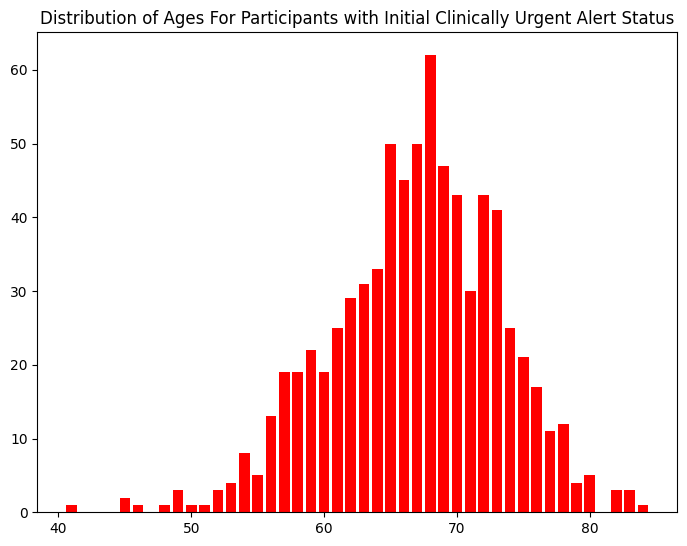

In [44]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in urgent_ids])))]

age_counts = participant_df['AgeAtDx'].value_counts().to_dict()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ages = age_counts.keys()
counts = [age_counts[age] for age in ages]
ax.bar(ages,counts, color='r')
ax.set_title('Distribution of Ages For Participants with Initial Clinically Urgent Alert Status')
plt.show()

# Alerting Domains

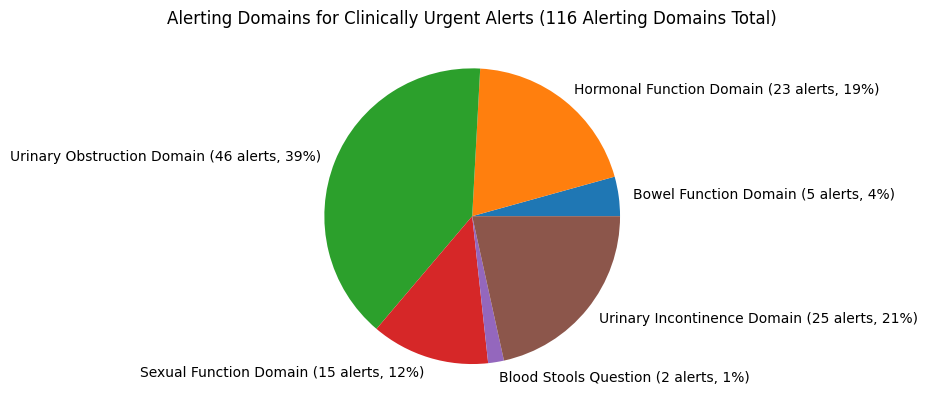

In [34]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()

In [ ]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()